https://github.com/nisode/MSDS/tree/main/Deep%20Learning

# Task

Our task is to generate 7000-10000 monet style images.

We are given 300, 256pi x 256pi monet paintings and 7028 photos sized 256x256.

Expected output is also 256pi x 256pi.

Due to the incredibly lackluster amount of information and guidance we are given going into this, almost all of this was following on the official tutorial notebook by Amy Jang and those notebooks that followed her, so many thanks to them.

Official Tutorial Notebook by Amy Jang: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

First we will import the relevant libraries and set usage to TPU.

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

#using TPU - by Amy Jang
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470


2022-10-11 08:55:23.225082: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-10-11 08:55:23.225168: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-10-11 08:55:23.229818: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-10-11 08:55:23.230043: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


Number of replicas: 8
2.4.1


# Load Data

We will load the images from tfrec format into monet_ds and photos_ds. Most of this code is provided by the tutorial notebook and tensorflow's cyclegan page. 

1. normalize from [0,255] to [-1, 1]
2. decode image - 3 channels for color
3. increase data by adding jittering by resizing to bigger image, random cropping back to original size, and mirroring.

In [8]:
def load_data():
    
    # code by Amy Jang and https://www.tensorflow.org/tutorials/generative/cyclegan
    
    GCS_PATH = KaggleDatasets().get_gcs_path()
    MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))

    PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))


    AUTOTUNE = tf.data.experimental.AUTOTUNE
    IMAGE_SIZE = [256, 256]

    def normalize(image):
        return (tf.cast(image, tf.float32) / 127.5) - 1

    def decode_image(image):
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.reshape(image, [*IMAGE_SIZE, 3])
        return image

    def random_crop(image):
        cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
        return cropped_image

    def random_jitter(image):
        image = tf.image.resize(image, [int(256*1.3), int(256*1.3)],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        image = random_crop(image)
        return image

    def flip(image):
        return tf.image.flip_left_right(image)

    def read_tfrecord(example):
        tfrecord_format = {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.string)
        }
        example = tf.io.parse_single_example(example, tfrecord_format)
        image = decode_image(example['image'])
        return image
    
    #alternative concatonate load:https://www.kaggle.com/code/jesperdramsch/understanding-and-improving-cyclegans-tutorial
    def load_dataset(filenames, labeled=False, ordered=False, repeats=100):
        dataset = tf.data.TFRecordDataset(filenames)
        dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
        dataset = dataset.concatenate(dataset.map(flip, num_parallel_calls=AUTOTUNE).shuffle(100000))
        dataset = dataset.concatenate(dataset.map(random_jitter, num_parallel_calls=AUTOTUNE).shuffle(10000, reshuffle_each_iteration=True).repeat(repeats))
        dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE).shuffle(10000)
        return dataset


    monet_ds = load_dataset(MONET_FILENAMES, labeled=True, repeats=40).batch(100, drop_remainder=True)
    photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True, repeats=2).batch(100, drop_remainder=True)
    return monet_ds, photo_ds

monet_ds, photo_ds = load_data()

2022-10-11 08:55:30.300978: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-11 08:55:30.375443: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Visualize Images

Let's take a look at 10 images from each dataset. This after jittering is added to some of them.

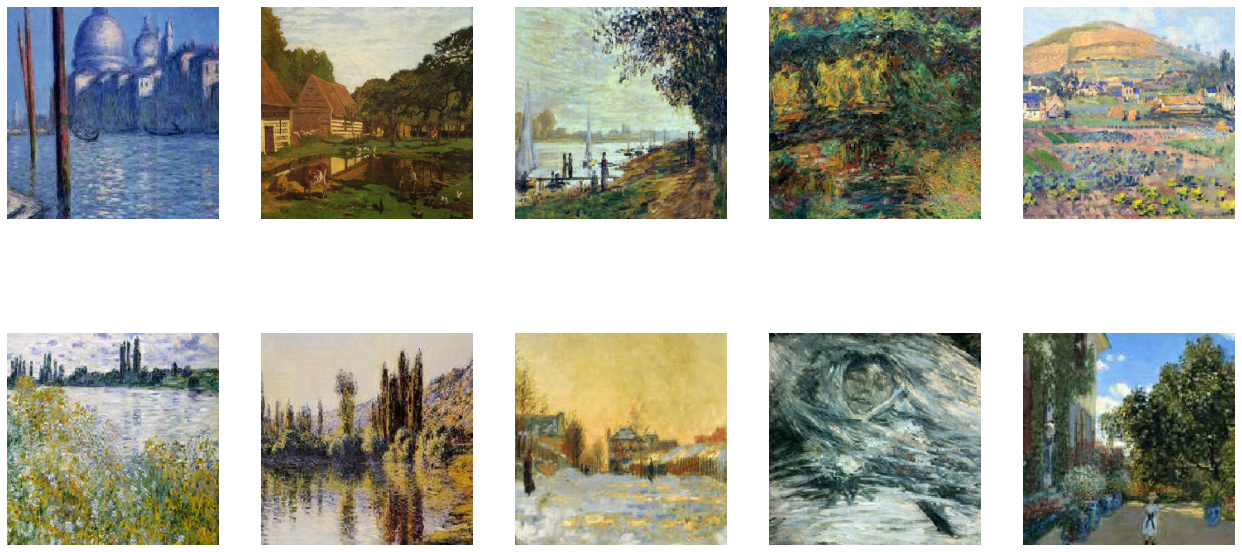

In [9]:
def view_images(ds):
    image = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()

    fig = plt.figure(figsize=(22, 11))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1)
        ax.set_axis_off()
        ax.imshow(image[i] / 2 + .5)
    

view_images(monet_ds)

I don't know anything about art, but I can see there is some style to monet's pictures. The styling isn't that consistent across all paintings as some are more "realism styled" than others like for example the painting on the bottom right. That looks a little like a photograph. The amount of realism vs surrealism? is not consistent across all paintings so it may be difficult for the model to pick up.

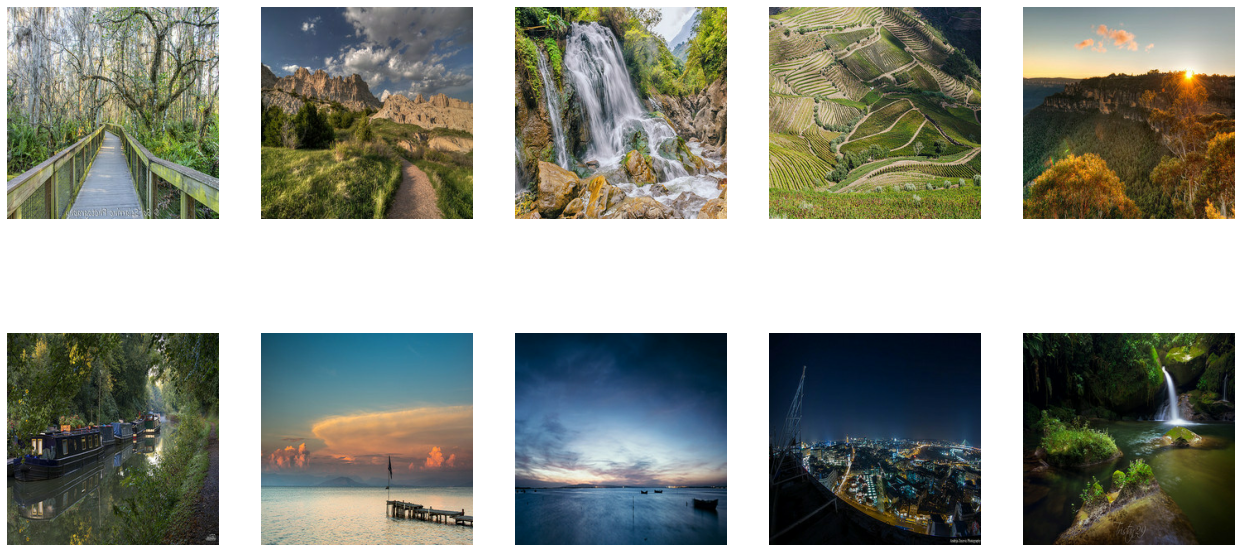

In [10]:
view_images(photo_ds)

The photos have a wide variety as well and with a lot of differing colors so I wonder how the generator will react to this. 

# Model

I tried this competition using DCGAN to generate images from scratch and the kind of pictures it was generating after 30 epochs was basically just dots. I think that the model had trouble generating images from scratch since the images were so different form each other and generating 7000 of these sounded like a bad idea. I tried to increasing the amount of parameters in the generator and discriminator, but I would constantly get out of memory errors when running on GPU. The total number of parameters was probably something like 10 million. I'm not sure what's going on here and I wish we were given more explanation and guidance. As a result the rest of this will just be trying to play around with the cyclegan provided by the tutorial.

# Build the generator

Althought CycleGAN wasn't covered in class, it is clear that cyclegan is used for transfering styles which is more suitable for this problem.

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2. What this really means is that each downsample is a 4x4 filter with stride 2 and this effectively halves the size until we get down to 1.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons. This is what the tutorial uses, but since I have a bactch of 100 here I don't know exactly know if instance is more appropriate than batch.

In [11]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

This will double our double our sizes and build it back up to the appropriate size. According to many other notebooks, downsample and discriminator supposedly do better with LeakyReLU while upsample tends to do better with regular ReLU.

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

Generator will need to output size of 256x256x3

In [13]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification. The discriminator and generator will help each other learn.

In [14]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

I believe the with strategy.scope() setup is to put things to parallelize for TPU.

In [15]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss. The loss function being used is tf.keras.losses.BinaryCrossentropy().

In [18]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [19]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [20]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [21]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

Adam as the opitmizer and 2e-4 as the learning rate tends to do well according to other notebooks.

In [22]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [25]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
246/246 [==============================] - 183s 300ms/step - monet_gen_loss: 5.1110 - photo_gen_loss: 5.4097 - monet_disc_loss: 0.5958 - photo_disc_loss: 0.4965
Epoch 2/25


2022-10-11 09:00:13.235069: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 12186, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665478813.231771087","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 12186, Output num: 0","grpc_status":3}


246/246 [==============================] - 76s 300ms/step - monet_gen_loss: 4.0124 - photo_gen_loss: 4.4721 - monet_disc_loss: 0.5219 - photo_disc_loss: 0.3836
Epoch 3/25
246/246 [==============================] - 76s 299ms/step - monet_gen_loss: 3.8624 - photo_gen_loss: 4.3418 - monet_disc_loss: 0.5827 - photo_disc_loss: 0.4780
Epoch 4/25
246/246 [==============================] - 76s 300ms/step - monet_gen_loss: 3.5264 - photo_gen_loss: 3.8533 - monet_disc_loss: 0.6023 - photo_disc_loss: 0.5377
Epoch 5/25
246/246 [==============================] - 76s 299ms/step - monet_gen_loss: 3.3888 - photo_gen_loss: 3.6047 - monet_disc_loss: 0.5961 - photo_disc_loss: 0.5350
Epoch 6/25
246/246 [==============================] - 76s 300ms/step - monet_gen_loss: 3.1993 - photo_gen_loss: 3.5402 - monet_disc_loss: 0.6182 - photo_disc_loss: 0.5219
Epoch 7/25
246/246 [==============================] - 76s 299ms/step - monet_gen_loss: 3.1780 - photo_gen_loss: 3.5231 - monet_disc_loss: 0.6164 - photo_dis

# Results

# Visualize our Monet-esque photos

2022-10-11 09:31:15.154929: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 71750, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665480675.153423710","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 71750, Output num: 0","grpc_status":3}


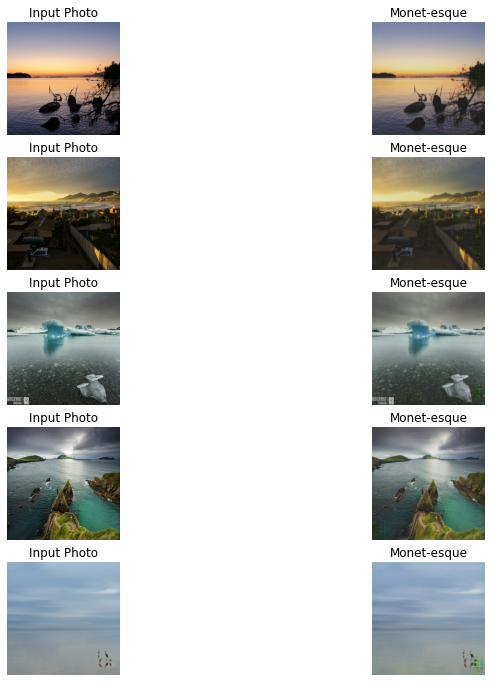

In [26]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In this run it is quite difficult to see if there is very much monet in the photo transformation. The low pixel quality does make it more difficult to see, but in the run without adding jittering, it showed a very pronounced checkered pattern filter on top of the photos. These monet-esque transformations look much more photo than artistic. There is some bluring and subtle differences so it is definitely doing something. Just not sure exactly what. Probably overshot as monet generator went increasingly up.

Let's do a version with early stopping on monet generator loss to see if it gives a better generated image.

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint

with strategy.scope():
    monet_generator2 = Generator() # transforms photos to Monet-esque paintings
    photo_generator2 = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator2 = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator2 = Discriminator() # differentiates real photos and generated photos
    
with strategy.scope():
    cycle_gan_model2 = CycleGan(
        monet_generator2, photo_generator2, monet_discriminator2, photo_discriminator2
    )

    cycle_gan_model2.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

checkpoint = tf.keras.callbacks.EarlyStopping(monitor='total_monet_gen_loss', mode='min', verbose=1, patience=3)
cycle_gan_model2.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
    callbacks=[checkpoint]
)

Epoch 1/25
246/246 [==============================] - 190s 304ms/step - monet_gen_loss: 3.3666 - photo_gen_loss: 3.4234 - monet_disc_loss: 0.6482 - photo_disc_loss: 0.6463
Epoch 2/25


2022-10-11 10:30:14.655181: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 419693, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665484214.655049391","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 419693, Output num: 0","grpc_status":3}


246/246 [==============================] - 77s 302ms/step - monet_gen_loss: 2.7984 - photo_gen_loss: 2.8594 - monet_disc_loss: 0.6172 - photo_disc_loss: 0.6094
Epoch 3/25
246/246 [==============================] - 77s 303ms/step - monet_gen_loss: 2.8061 - photo_gen_loss: 2.9392 - monet_disc_loss: 0.6079 - photo_disc_loss: 0.5788
Epoch 4/25
246/246 [==============================] - 77s 302ms/step - monet_gen_loss: 2.7491 - photo_gen_loss: 2.9920 - monet_disc_loss: 0.6067 - photo_disc_loss: 0.5673
Epoch 5/25
246/246 [==============================] - 77s 305ms/step - monet_gen_loss: 2.6758 - photo_gen_loss: 2.9109 - monet_disc_loss: 0.6190 - photo_disc_loss: 0.5829
Epoch 6/25
246/246 [==============================] - 77s 304ms/step - monet_gen_loss: 2.5971 - photo_gen_loss: 2.8374 - monet_disc_loss: 0.6218 - photo_disc_loss: 0.5776
Epoch 7/25
246/246 [==============================] - 77s 305ms/step - monet_gen_loss: 2.5507 - photo_gen_loss: 2.7833 - monet_disc_loss: 0.6237 - photo_dis

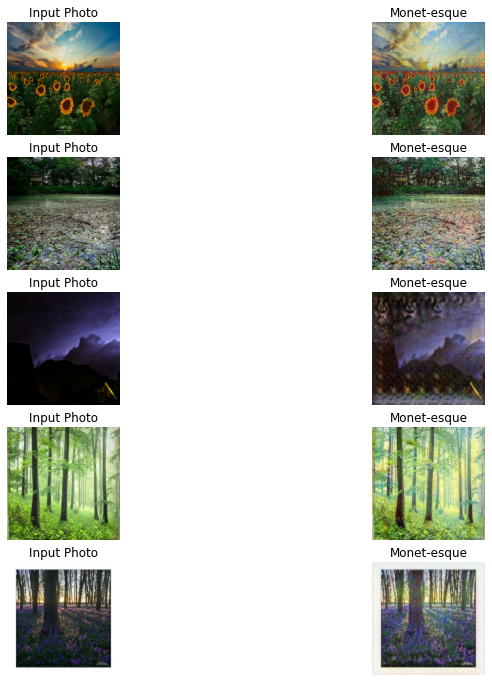

In [41]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator2(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

I dont know if this callback function actually did anything, but the monet generator loss was much lower this time. As a result we can see that that this time the photos generated more monet-esque style. Although not the pronounced checkered styled you see in many of the other notebooks, it does look more like a painintg and the color palettes better match the style. I think it's especially interesting what it did to the darker colored areas. 

Let's try one with much lower learning rates of 2e-5 compared to the previous 2e-4:

In [42]:
with strategy.scope():
    monet_generator3 = Generator() # transforms photos to Monet-esque paintings
    photo_generator3 = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator3 = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator3 = Discriminator() # differentiates real photos and generated photos

with strategy.scope():
    monet_generator_optimizer2 = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
    photo_generator_optimizer2 = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

    monet_discriminator_optimizer2 = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
    photo_discriminator_optimizer2 = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
    
with strategy.scope():
    cycle_gan_model3 = CycleGan(
        monet_generator3, photo_generator3, monet_discriminator3, photo_discriminator3
    )

    cycle_gan_model3.compile(
        m_gen_optimizer = monet_generator_optimizer2,
        p_gen_optimizer = photo_generator_optimizer2,
        m_disc_optimizer = monet_discriminator_optimizer2,
        p_disc_optimizer = photo_discriminator_optimizer2,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

checkpoint = tf.keras.callbacks.EarlyStopping(monitor='total_monet_gen_loss', mode='min', verbose=1, patience=3)
cycle_gan_model3.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
    callbacks=[checkpoint]
)

Epoch 1/25
246/246 [==============================] - 184s 302ms/step - monet_gen_loss: 10.3652 - photo_gen_loss: 10.6981 - monet_disc_loss: 0.6575 - photo_disc_loss: 0.6514
Epoch 2/25


2022-10-11 11:33:54.240264: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 494526, Output num: 3
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665488034.240119135","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 494526, Output num: 3","grpc_status":3}


246/246 [==============================] - 77s 304ms/step - monet_gen_loss: 5.4551 - photo_gen_loss: 5.5712 - monet_disc_loss: 0.6052 - photo_disc_loss: 0.6034
Epoch 3/25
246/246 [==============================] - 77s 304ms/step - monet_gen_loss: 5.0054 - photo_gen_loss: 5.1252 - monet_disc_loss: 0.5288 - photo_disc_loss: 0.5225
Epoch 4/25
246/246 [==============================] - 77s 302ms/step - monet_gen_loss: 4.6757 - photo_gen_loss: 4.8149 - monet_disc_loss: 0.5339 - photo_disc_loss: 0.4902
Epoch 5/25
246/246 [==============================] - 78s 303ms/step - monet_gen_loss: 4.4281 - photo_gen_loss: 4.6822 - monet_disc_loss: 0.5597 - photo_disc_loss: 0.4301
Epoch 6/25
246/246 [==============================] - 77s 304ms/step - monet_gen_loss: 4.2536 - photo_gen_loss: 4.5149 - monet_disc_loss: 0.4740 - photo_disc_loss: 0.3631
Epoch 7/25
246/246 [==============================] - 77s 303ms/step - monet_gen_loss: 4.1185 - photo_gen_loss: 4.3970 - monet_disc_loss: 0.4395 - photo_dis

2022-10-11 12:05:21.830695: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 554077, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665489921.830608725","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 554077, Output num: 0","grpc_status":3}


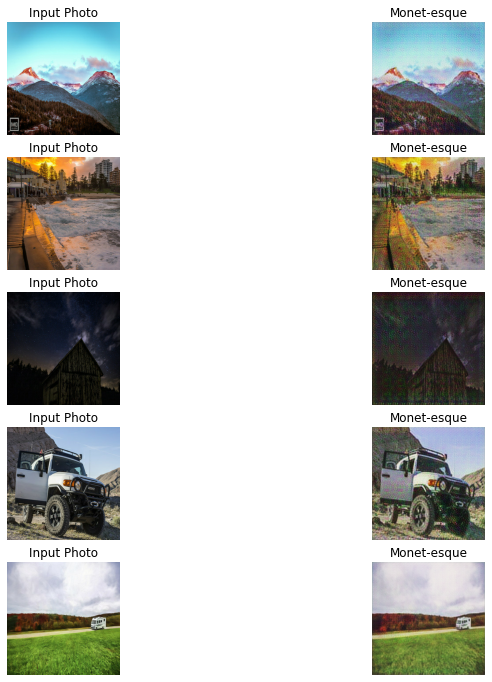

In [43]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator3(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

With a lower learning the rate of 2e-5 instead of 2e-4, the learning was more consistently going down, but it would need a lot more epochs to get to a better monet style transformation. Most of these still look just about the same, but there is some blurring and slight color changes. I would say 2e-4 works better for smaller epoch sizes while 2e-5 may work better if you have more time to train.

Now let's test slightly different loss functions at a smaller 10 epochs each. For the first one, I will try to weight the real_ross higher at 70% compared ot the generated_loss at 30%. Mostly just curious if the results will be different, but maybe it will work better because we would probably weight real loss higher?

In [44]:

with strategy.scope():
    monet_generator4 = Generator() # transforms photos to Monet-esque paintings
    photo_generator4 = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator4 = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator4 = Discriminator() # differentiates real photos and generated photos

with strategy.scope():
    def discriminator_loss2(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return 0.7*real_loss + 0.3*generated_loss
    
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss
    
with strategy.scope():
    cycle_gan_model4 = CycleGan(
        monet_generator4, photo_generator4, monet_discriminator4, photo_discriminator4
    )

    cycle_gan_model4.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss2,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

checkpoint = tf.keras.callbacks.EarlyStopping(monitor='total_monet_gen_loss', mode='min', verbose=1, patience=3)
cycle_gan_model4.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
246/246 [==============================] - 187s 304ms/step - monet_gen_loss: 3.0290 - photo_gen_loss: 3.0735 - monet_disc_loss: 0.5589 - photo_disc_loss: 0.5589
Epoch 2/10


2022-10-11 12:08:34.850585: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 565712, Output num: 3
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665490114.850476078","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 565712, Output num: 3","grpc_status":3}


246/246 [==============================] - 77s 303ms/step - monet_gen_loss: 2.5262 - photo_gen_loss: 2.6324 - monet_disc_loss: 0.5160 - photo_disc_loss: 0.4977
Epoch 3/10
246/246 [==============================] - 77s 303ms/step - monet_gen_loss: 2.5403 - photo_gen_loss: 2.7705 - monet_disc_loss: 0.5138 - photo_disc_loss: 0.4635
Epoch 4/10
246/246 [==============================] - 77s 302ms/step - monet_gen_loss: 2.5005 - photo_gen_loss: 2.7497 - monet_disc_loss: 0.5188 - photo_disc_loss: 0.4638
Epoch 5/10
246/246 [==============================] - 77s 304ms/step - monet_gen_loss: 2.3948 - photo_gen_loss: 2.6105 - monet_disc_loss: 0.5266 - photo_disc_loss: 0.4817
Epoch 6/10
246/246 [==============================] - 77s 304ms/step - monet_gen_loss: 2.3016 - photo_gen_loss: 2.5259 - monet_disc_loss: 0.5295 - photo_disc_loss: 0.4817
Epoch 7/10
246/246 [==============================] - 77s 303ms/step - monet_gen_loss: 2.2388 - photo_gen_loss: 2.4627 - monet_disc_loss: 0.5310 - photo_dis

2022-10-11 12:20:37.275035: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 590118, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665490837.274925238","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 590118, Output num: 0","grpc_status":3}


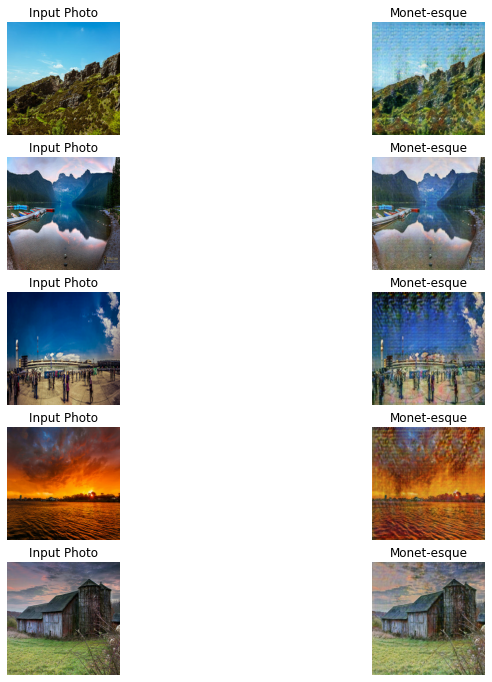

In [45]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator4(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

These have some quite nice monet-esque styling to them. I don't know if these pictures do work better, but you can see the hazy checkered backgrounds as well. Some of them look better than others like the bendy lake and mountain picture still looks very photographic in comparison.

I will try one more small loss function change where I half the cycle_loss by half to match the identity loss and maybe lower its effects.

In [47]:

with strategy.scope():
    monet_generator5 = Generator() # transforms photos to Monet-esque paintings
    photo_generator5 = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator5 = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator5 = Discriminator() # differentiates real photos and generated photos

with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return 0.5*total_disc_loss
    
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss2(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1 * 0.5

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss
    
with strategy.scope():
    cycle_gan_model5 = CycleGan(
        monet_generator5, photo_generator5, monet_discriminator5, photo_discriminator5
    )

    cycle_gan_model5.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss2,
        identity_loss_fn = identity_loss
    )

checkpoint = tf.keras.callbacks.EarlyStopping(monitor='total_monet_gen_loss', mode='min', verbose=1, patience=3)
cycle_gan_model5.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
246/246 [==============================] - 189s 305ms/step - monet_gen_loss: 2.2829 - photo_gen_loss: 2.3441 - monet_disc_loss: 0.6431 - photo_disc_loss: 0.6407
Epoch 2/10


2022-10-11 12:25:43.546981: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 606450, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665491143.546903093","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 606450, Output num: 0","grpc_status":3}


246/246 [==============================] - 77s 305ms/step - monet_gen_loss: 2.1094 - photo_gen_loss: 2.2272 - monet_disc_loss: 0.6133 - photo_disc_loss: 0.5903
Epoch 3/10
246/246 [==============================] - 77s 303ms/step - monet_gen_loss: 2.0913 - photo_gen_loss: 2.3858 - monet_disc_loss: 0.6235 - photo_disc_loss: 0.5668
Epoch 4/10
246/246 [==============================] - 77s 303ms/step - monet_gen_loss: 2.0297 - photo_gen_loss: 2.3975 - monet_disc_loss: 0.6322 - photo_disc_loss: 0.5657
Epoch 5/10
246/246 [==============================] - 77s 304ms/step - monet_gen_loss: 1.9701 - photo_gen_loss: 2.3996 - monet_disc_loss: 0.6390 - photo_disc_loss: 0.5647
Epoch 6/10
246/246 [==============================] - 77s 304ms/step - monet_gen_loss: 1.9365 - photo_gen_loss: 2.3290 - monet_disc_loss: 0.6412 - photo_disc_loss: 0.5745
Epoch 7/10
246/246 [==============================] - 77s 303ms/step - monet_gen_loss: 1.9213 - photo_gen_loss: 2.2916 - monet_disc_loss: 0.6359 - photo_dis

2022-10-11 12:37:38.301134: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 630856, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665491858.301021191","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 630856, Output num: 0","grpc_status":3}


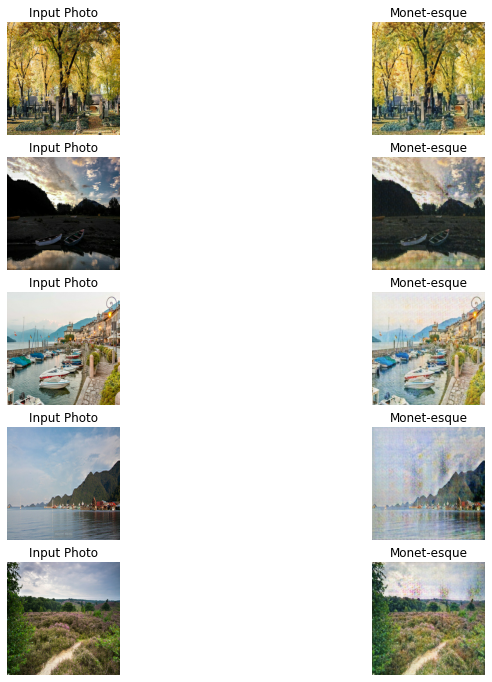

In [48]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator5(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Althought this code had low generated loss, these still look more photographic than the other attempts. There is a capturing of these darkened bands in the sky, but I'm not sure if that counts as monet-esque. 

| change | epochs | monet_gen_loss |
| --- | --- | --- |
| baseline | 25 | 4.0020 |
| early exit | 25 | 2.5572 |
| learning rate 2e-5 | 25 | 3.1606 |
| weighted discrim loss | 10 | 2.1149 |
| 0.5 cycle loss | 10 | 1.8763 |

# Conclusion

I don't think it is that reasonable to tabularize the generative losses because they seem a little relative. For example the weighted loss function trial had a higher generated loss of 2.1 or so while the halved cycle loss provided a lower generated loss at 1.87 but the pictures didn't look as Monet-like in my opinion. It is quite suspicious how low some of the ending runs were especially at low epochs so it's difficult for me to say what they really mean. I think the weighted discrim loss looked the best despite not having the lowest monet_gen_loss. For the future, it'd help a lot to learn how exactly these cyclegan functions work rather than letting the tutorial do the heavy lifting. The lack of explanation from class just made it a difficult point of entry. I believe a MINST type data set would have been better suited with what was explained. I'm still not entirely sure why the baseline did so much worse, but it's probably because the model ended up over shooting. I think it's clear cyclegan would be the best approach for this type of problem than something where you generate the picture from scratch.

# Create submission file

In [27]:
import PIL
! mkdir ../images

In [28]:
i = 1
for img in photo_ds:
    prediction = monet_generator2(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

2022-10-11 09:52:42.620480: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 346059, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665481962.620363417","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 346059, Output num: 0","grpc_status":3}


In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

References:

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

https://www.tensorflow.org/tutorials/generative/cyclegan

https://www.kaggle.com/code/jesperdramsch/understanding-and-improving-cyclegans-tutorial